# Data Simulation and analysis

Premilinary analysis for da ta simulation and analysis of WCE data

In [7]:
library(dplyr)
library(WCE)
library(purrr)

In [8]:
# Function to generate an individual time-dependent exposure history
# e.g. generate prescriptions of different durations and doses.
TDhist <- function(observation_time) {
  # Duration : lognormal distribution(0.5,0.8)
  duration <- 7 + 7 * round(rlnorm(1, meanlog = 0.5, sdlog = 0.8), 0)
  # in weeks

  # Dose : random assignment of values 0.5, 1, 1.5, 2, 2.5 and 3
  dose <- sample(seq(from = 0.5, to = 3, by = 0.5), size = 1)

  # Start with drug exposure
  vec <- rep(dose, duration)

  # Repeat until the vector is larger than observation_time
  while (length(vec) <= observation_time) {
      intermission <- 7 + 7 * round(rlnorm(1, meanlog = 0.5, sdlog = 0.8), 0) # in weeks
      duration <- 7 + 7 * round(rlnorm(1, meanlog = 0.5, sdlog = 0.8), 0) # in weeks
      dose <- sample(c(0.5, 1, 1.5, 2, 2.5, 3), size = 1)
      vec <- append(vec, c(rep(0, intermission), rep(dose, duration)))
  }

  return(vec[1:observation_time])
}

In [9]:
generate_Xmat <- function(observation_time,n_patients){
  Xmat = matrix(ncol = 1,
                nrow = n_patients * observation_time)
  Xmat[, 1] <- do.call("c", lapply(1:n_patients, function(i) TDhist(observation_time)))
  dim(Xmat) <- c(observation_time, n_patients)
  return(Xmat)
  }

## 1.2 Weight Function

In [10]:
# Scénario 1 - Exponential
exponential_function <- function(u_t) {
    return(7 * exp(-7 * u_t))
}
    

# Scénario 2 - Bi-Linearexponential_function <- function(u_t) {

bi_linear_function <- function(u_t) {
    ifelse((u_t) <= (50 / 365),
    1 - ((u_t) / (50 / 365)),
    0
    )
}

## Scénario 3 - Early peak

early_peak_function <- function(u_t) {
    return(dnorm(u_t, 0.04, 0.05))
}

## Scénario 4 - Inverted U
inverted_u_function <- function(u_t) {
    return(dnorm(u_t, 0.2, 0.06))
}

## Scénario 5 - Constant
constant_function <- function(u_t) {
    ifelse(u_t >= 0 & u_t <= 180 / 365,
    1 / 180,
    0
    )
}

scenario <- c(
    "exponential_function",
    # "bi_linear_function",
    "early_peak_function",
    "inverted_u_function",
    "constant_function"
)


In [11]:
exponential_function(1/365)
bi_linear_function(1/365)
exponential_function(1/365)
early_peak_function(1/365)
inverted_u_function(50/365)

[1] 6.867033

[1] 0.98

[1] 6.867033

[1] 6.044375

[1] 3.830451

In [13]:
Xmat <- generate_Xmat(365,500)
wce_vector(100,early_peak_function,Xmat)


ERROR: Error in wce_vector(100, early_peak_function, Xmat): could not find function "wce_vector"


In [14]:
early_peak_function(1)

[1] 7.124939e-80

## 1.3 Event Generation

In [15]:
# Function to obtain WCE vector
wce_vector <- function(u, scenario, Xmat,normalization) {
    t <- 1:u

    scenario_function <- do.call(scenario, list((u - t) / 365))/normalization

    # Normalization (THIS SHOULD NOT BE HERE, we have to rethink the codebase and enter the scenario as a vector )
    wce <- scenario_function * Xmat[t,]

    if (u == 1) {
        res <- wce
    } else {
        res <- apply(wce, 2, sum)
    }

    return(res)
}


In [16]:
# Function to generate event times and censoring times
event_censor_generation <- function(max_time,n_patients) {
    # Event times : Uniform[1;365] for all scenarios
  
    eventRandom <- round(runif(n_patients, 1, max_time), 0)

    # Censoring times : Uniform[1;730] for all scenarios
    censorRandom <- round(runif(n_patients, 1, max_time*2), 0)

    return(list(eventRandom = eventRandom,
                censorRandom = censorRandom))
}

In [17]:
# Function for 'the final step of the permutational algorithm'
matching_algo <- function(wce_mat) {
    n_patient <- ncol(wce_mat)
    events_generation <- event_censor_generation(dim(wce_mat)[1],dim(wce_mat)[2])
    
    df_event <- data.frame(patient = 1:n_patient,
                           eventRandom = events_generation$eventRandom,
                           censorRandom = events_generation$censorRandom)
    df_event <- df_event %>%
        group_by(patient) %>%
        mutate(FUP_Ti = min(eventRandom, censorRandom)) %>%
        mutate(event = ifelse(FUP_Ti == eventRandom, 1, 0)) %>%
        ungroup() %>%
        arrange(FUP_Ti)

    # init
    patient_order <- df_event$patient
    j = 1
    id <- 1:n_patient
    wce_mat_df <- wce_mat %>% as.data.frame()
    matching_result <- data.frame()

    # Iterative matching, start with the lowest FUP
    for (i in patient_order) {
        event <- df_event[j, "event"] %>% pull()
        time_event <- df_event[j, "FUP_Ti"] %>% pull()
        
        
        if(event == 0) {
            # If no event, all probabilities are the same
            sample_id <- sample(id, 1)
        } else if(event == 1) {
            # If event, matching with different probabilities
          
            wce_matrix <- wce_mat_df %>% select(paste0("V", id)) %>% as.matrix()
            proba <- (4 * wce_matrix[time_event,]) / sum(4 * wce_matrix[time_event,])
            sample_id <- sample(id, 1, prob = proba)
        }

        matching_result <- rbind(matching_result,
                                 data.frame(id_patient = i,
                                            id_dose_wce = sample_id))
        id <- id[!id %in% sample_id]
        j = j + 1

        # Stop when last id of iterative algo
        if(length(id) == 1) {
            matching_result <- rbind(matching_result,
                                     data.frame(id_patient = patient_order[n_patient],
                                                id_dose_wce = id))
            return(list(matching_result = matching_result,
                        df_event = df_event,
                        patient_order = patient_order))
        }
    }
}

# Function to render dataset after the matching algo
get_dataset <- function(Xmat, wce_mat) {
    df_wce <- data.frame()
    Xmat_df <- Xmat %>%
        as.data.frame()
    matching_result <- matching_algo(wce_mat)

    for (i in matching_result$patient_order) {
        fu <- matching_result$df_event[matching_result$df_event$patient == i, "FUP_Ti"] %>% pull()
        event_patient <- matching_result$df_event[matching_result$df_event$patient == i, "event"] %>% pull()

        if(event_patient == 1) {
            event_vec <- c(rep(0, (fu-1)), 1)
        } else {
            event_vec <- rep(0, fu)
        }
        
        id_dose <- matching_result$matching_result[matching_result$matching_result$id_patient == i, "id_dose_wce"]
        df_dose <- data.frame(patient = rep(i, fu),
                              start = 0:(fu-1),
                              stop = 1:fu,
                              event = event_vec,
                              dose = Xmat_df[1:fu, paste0("V", id_dose)])
        df_wce <- rbind(df_wce, df_dose)
    }

    return(df_wce)
}


# Simulation

In [18]:
# Function to simulate right constrained and unconstrained WCE with the same1
# dataset according to a specif@installed R Toolsic scenario
Simulate_WCE<- function(scenario, Xmat,cutoff,normalization) {

    wce_mat <- do.call("rbind", lapply(1:dim(Xmat)[1], wce_vector, scenario = scenario, Xmat = Xmat,normalization = normalization))
    df_wce <- get_dataset(Xmat = Xmat, wce_mat = wce_mat)
    

    # cutoff at 180 - right constrained and unconstrained with the same dataset
    wce_right_constrained <- WCE(df_wce, "Cox", 1:3, cutoff, constrained = "right",
                                 id = "patient", event = "event", start = "start",
                                 stop = "stop", expos = "dose")

    wce_unconstrained <- WCE(df_wce, "Cox", 1:3, cutoff, constrained = FALSE,
                             id = "patient", event = "event", start = "start",
                             stop = "stop", expos = "dose")

    WCEmat_right_constrained <- wce_right_constrained$WCEmat[which.min(wce_right_constrained$info.criterion),]

    MSE_right_constrained <-  mean((calcul_exposition(scenario,normalization) - WCEmat_right_constrained )^2)



    WCEmat_unconstrained <- wce_unconstrained$WCEmat[which.min(wce_unconstrained$info.criterion),]

    MSE_unconstrained <-  mean((calcul_exposition(scenario,normalization) - WCEmat_unconstrained )^2)
    
    results_right_constrained = list(WCEmat = WCEmat_right_constrained,
                                     BIC = min(wce_right_constrained$info.criterion),
                                     MSE = MSE_right_constrained)
    
    results_unconstrained = list(WCEmat = WCEmat_unconstrained,
                                 BIC = min(wce_unconstrained$info.criterion),
                                 MSE = MSE_unconstrained)
        
    # Best result according to BIC
    return(list(results_right_constrained = results_right_constrained,
                results_unconstrained = results_unconstrained))
}

# Test Script

In [19]:
simulate_with_bootstraps <- function(n_bootstraps, number_patients, observation_time, scenario,cutoff,normalization){
    print("################ Start simulation #################")
  
    start_time = Sys.time()
    
    print(paste("simulation of ",n_bootstraps,"bootstraps"))
    
    
    right_constrained <- list()
    right_constrained_BIC <- list()
    right_constrained_MSE <- list()
    unconstrained <- list()
    unconstrained_BIC <-  list()
    unconstrained_MSE <-  list()


    for (i in 1:n_bootstraps){

        print(paste("Simulation of bootstrap",i))
    
        Xmat <- generate_Xmat(observation_time,number_patients)
        simulation <- Simulate_WCE(scenario,Xmat,cutoff,normalization)
        right_constrained <- append(right_constrained,list(simulation$results_right_constrained$WCEmat))
        right_constrained_BIC <- append(right_constrained_BIC,list(simulation$results_right_constrained$BIC))
        right_constrained_MSE <- append(right_constrained_MSE,list(simulation$results_right_constrained$MSE))
        unconstrained <- append(unconstrained,list(simulation$results_unconstrained$WCEmat))
        unconstrained_BIC <- append(unconstrained_BIC,list(simulation$results_unconstrained$BIC))   
        unconstrained_MSE <- append(unconstrained_MSE,list(simulation$results_unconstrained$MSE))

    

    }    


    list_simulations <- list(right_constrained=right_constrained,
                             right_constrained_BIC = right_constrained_BIC,
                             right_constrained_MSE = right_constrained_MSE,
                             unconstrained = unconstrained,
                             unconstrained_BIC = unconstrained_BIC,
                             unconstrained_MSE = unconstrained_MSE)
    end_time = Sys.time()
    time = difftime(end_time, start_time, units = "sec")
    print(paste("This simulation took : ", round(time), " seconds"))

    return(list_simulations)
}

In [42]:


#exponential_function(1)
#print(early_peak_function(2))
#
#expo_decay_list <- lapply((0:180)/365, exponential_function)
#expo_decay <- do.call("rbind", expo_decay_list) / 365
#
#ep_decay_list <- lapply((0:180)/365, early_peak_function)
#ep_decay <- do.call("rbind", ep_decay_list) / 365
#
#print(ep_decay)



calcul_exposition <- function(scenario,normalization){
    expo_list <- lapply((1:180)/365, scenario)
    expo <- do.call("rbind", expo_list)/365
    return(expo)
}


In [52]:
analyze_simulations <- function(list_simulations,correct_shape = ep_decay){

    right_constrained <- do.call(rbind,list_simulations$right_constrained)
    BIC_right_constrained <- mean(unlist(list_simulations$right_constrained_BIC))
    print(BIC_right_constrained)
    unconstrained <- do.call(rbind,list_simulations$unconstrained)
    BIC_unconstrained <- mean(unlist(list_simulations$unconstrained_BIC))
    print(BIC_unconstrained)




    # get MSE 
    MSE_list_right_constrained <- c()
    for (simulation in right_constrained){
        MSE <- append(MSEMSE_list_right_constrained)

    }
    MSE_list_unconstrained <- c()
    for (list in list_simulations){

    }
    

    t(right_constrained) %>% 
        matplot(, type = "l", col = "black", lty = 1)
    matlines(correct_shape, type = "l", col = "red", lty = 1)

    t(unconstrained) %>% 
        matplot(, type = "l", col = "black", lty = 1)
    matlines(correct_shape, type = "l", col = "red", lty = 1)    


    
}

In [47]:
normalize_function <- function(scenario, sum, upper_time){
  integration <- integrate(scenario, lower = 0, upper = upper_time)$value
  return(integration)
}

In [46]:
normalize_function(bi_linear_function,1,180/365)

[1] 0.0684929

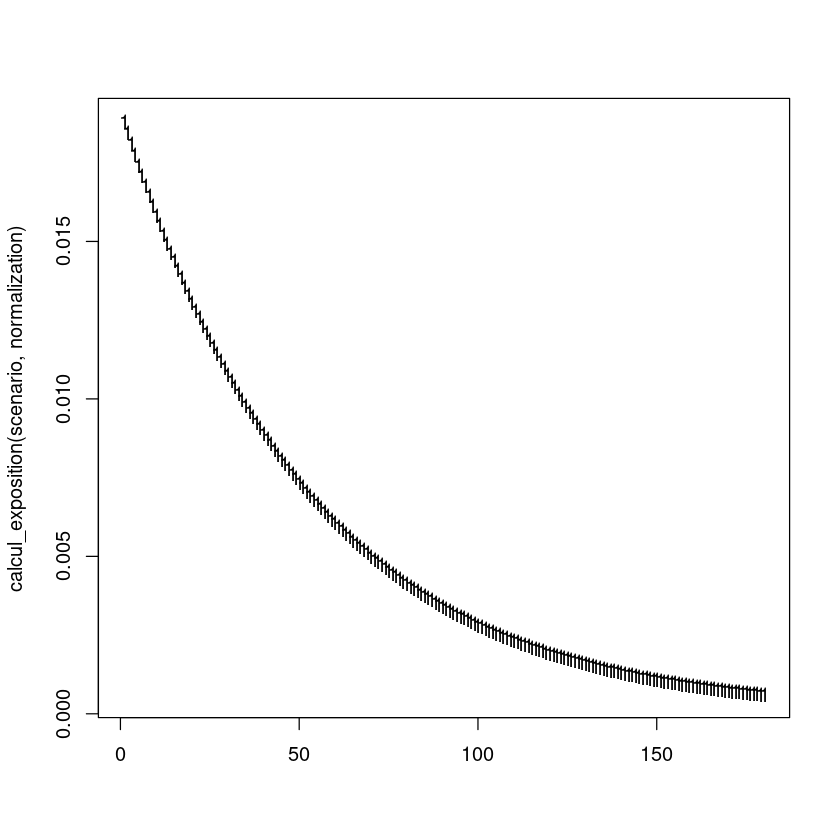

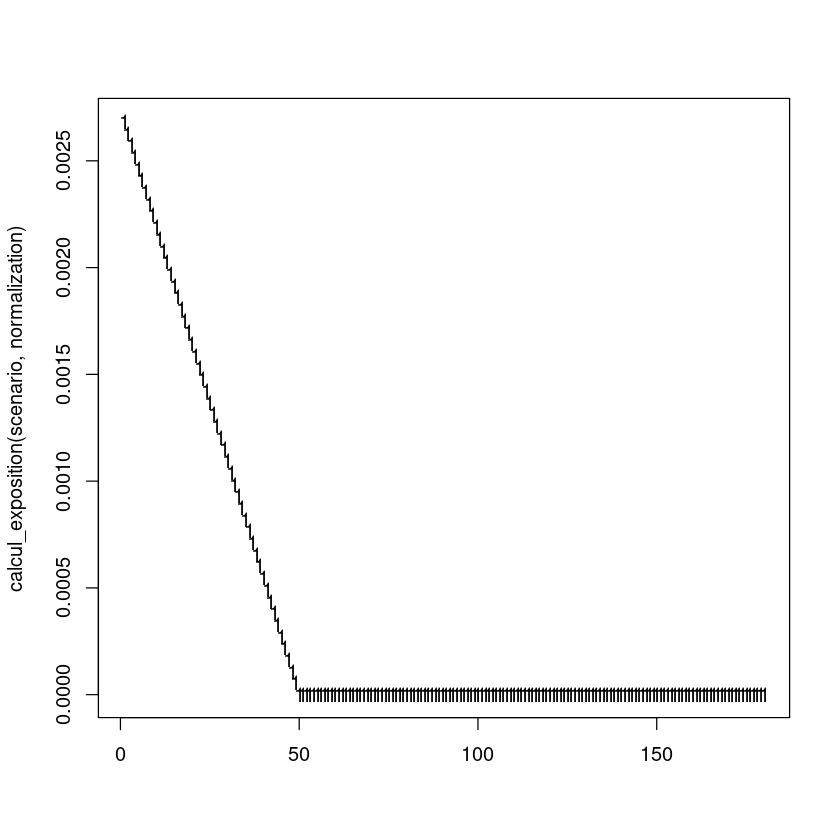

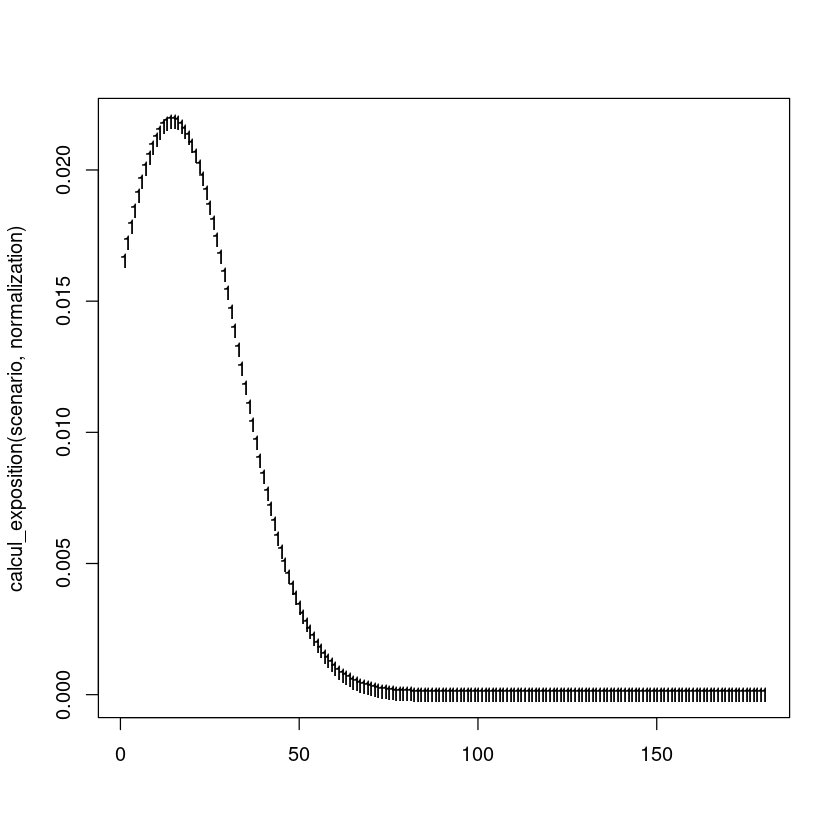

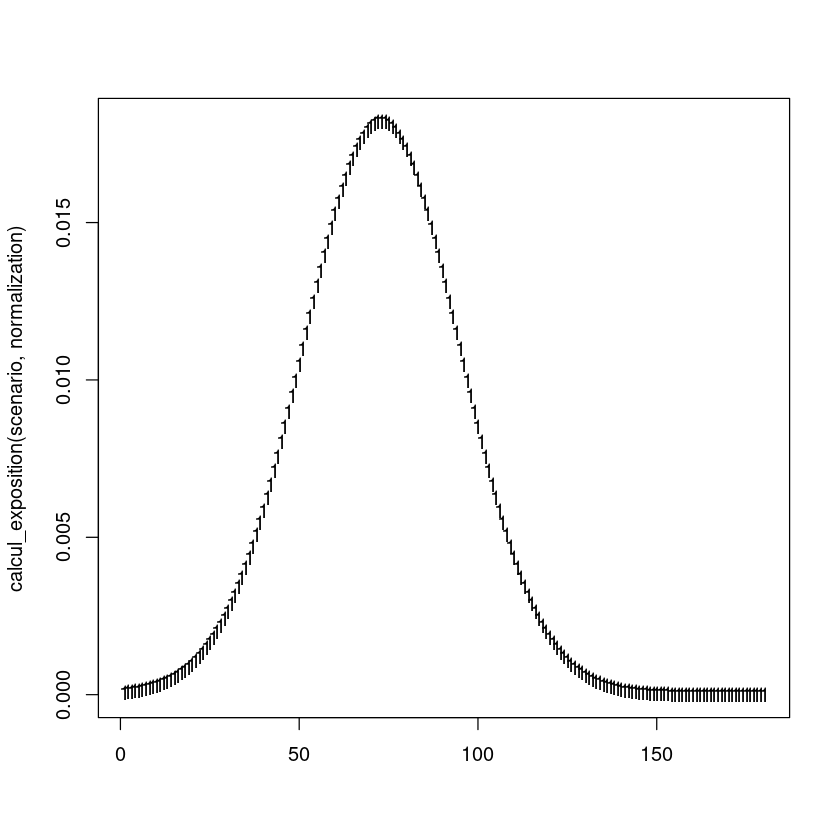

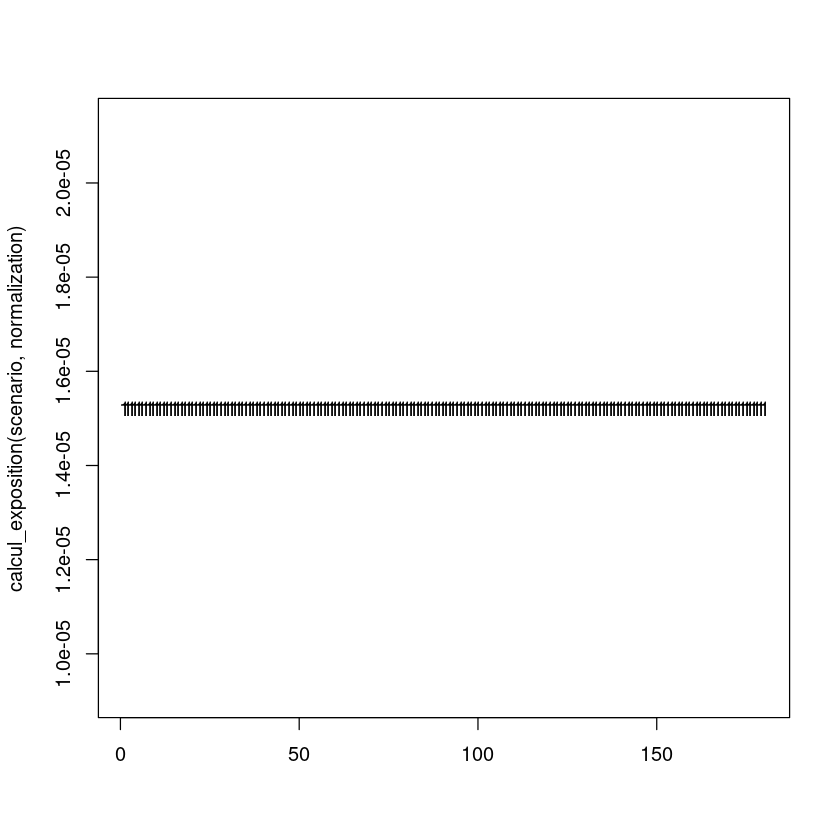

In [45]:
list_scenario <- c(exponential_function,bi_linear_function,early_peak_function,inverted_u_function,constant_function)

for (scenario in list_scenario){
    normalization <- normalize_function(scenario,1,180/365)
    matplot(calcul_exposition(scenario,normalization))
}


In [26]:
scenario <- exponential_function
cutoff <- 180
normalization <- normalize_function(scenario = scenario, 1, cutoff/365)
print(normalization)
 

list_simulations <- simulate_with_bootstraps(n_bootstraps = 2,
                                           number_patients = 500,
                                           observation_time = 365,
                                           scenario = scenario,
                                           cutoff = cutoff,
                                           normalization =  normalization)

[1] 0.9683195


[1] "################ Start simulation #################"
[1] "simulation of  2 bootstraps"
[1] "Simulation of bootstrap 1"
[1] "Simulation of bootstrap 2"
[1] "This simulation took :  21  seconds"


In [49]:
list_simulations

$right_constrained
$right_constrained[[1]]
          t1           t2           t3           t4           t5           t6 
2.996107e-02 2.912372e-02 2.830437e-02 2.750283e-02 2.671888e-02 2.595232e-02 
          t7           t8           t9          t10          t11          t12 
2.520294e-02 2.447054e-02 2.375491e-02 2.305585e-02 2.237315e-02 2.170660e-02 
         t13          t14          t15          t16          t17          t18 
2.105600e-02 2.042114e-02 1.980183e-02 1.919784e-02 1.860898e-02 1.803504e-02 
         t19          t20          t21          t22          t23          t24 
1.747581e-02 1.693109e-02 1.640068e-02 1.588436e-02 1.538193e-02 1.489319e-02 
         t25          t26          t27          t28          t29          t30 
1.441793e-02 1.395594e-02 1.350702e-02 1.307096e-02 1.264756e-02 1.223661e-02 
         t31          t32          t33          t34          t35          t36 
1.183790e-02 1.145123e-02 1.107640e-02 1.071319e-02 1.036141e-02 1.002084e-02 
         t37          t38          t39          t40          t41          t42 
9.691282e-03 9.372528e-03 9.064373e-03 8.766611e-03 8.479036e-03 8.201442e-03 
         t43          t44          t45          t46          t47          t48 
7.933624e-03 7.675376e-03 7.426492e-03 7.186766e-03 6.955992e-03 6.733966e-03 
         t49          t50          t51          t52          t53          t54 
6.520480e-03 6.315330e-03 6.118309e-03 5.929211e-03 5.747832e-03 5.573964e-03 
         t55          t56          t57          t58          t59          t60 
5.407403e-03 5.247942e-03 5.095376e-03 4.949499e-03 4.810106e-03 4.676989e-03 
         t61          t62          t63          t64          t65          t66 
4.549945e-03 4.428766e-03 4.313248e-03 4.203183e-03 4.098368e-03 3.998595e-03 
         t67          t68          t69          t70          t71          t72 
3.903659e-03 3.813354e-03 3.727475e-03 3.645815e-03 3.568170e-03 3.494332e-03 
         t73          t74          t75          t76          t77          t78 
3.424097e-03 3.357258e-03 3.293611e-03 3.232948e-03 3.175065e-03 3.119755e-03 
         t79          t80          t81          t82          t83          t84 
3.066812e-03 3.016032e-03 2.967208e-03 2.920134e-03 2.874605e-03 2.830415e-03 
         t85          t86          t87          t88          t89          t90 
2.787358e-03 2.745228e-03 2.703819e-03 2.662926e-03 2.622344e-03 2.581865e-03 
         t91          t92          t93          t94          t95          t96 
2.541321e-03 2.500688e-03 2.459978e-03 2.419202e-03 2.378373e-03 2.337503e-03 
         t97          t98          t99         t100         t101         t102 
2.296605e-03 2.255690e-03 2.214770e-03 2.173858e-03 2.132966e-03 2.092105e-03 
        t103         t104         t105         t106         t107         t108 
2.051289e-03 2.010529e-03 1.969837e-03 1.929225e-03 1.888706e-03 1.848292e-03 
        t109         t110         t111         t112         t113         t114 
1.807994e-03 1.767826e-03 1.727799e-03 1.687924e-03 1.648216e-03 1.608684e-03 
        t115         t116         t117         t118         t119         t120 
1.569343e-03 1.530203e-03 1.491277e-03 1.452577e-03 1.414115e-03 1.375903e-03 
        t121         t122         t123         t124         t125         t126 
1.337954e-03 1.300280e-03 1.262892e-03 1.225803e-03 1.189025e-03 1.152570e-03 
        t127         t128         t129         t130         t131         t132 
1.116450e-03 1.080678e-03 1.045265e-03 1.010224e-03 9.755666e-04 9.413051e-04 
        t133         t134         t135         t136         t137         t138 
9.074516e-04 8.740184e-04 8.410174e-04 8.084609e-04 7.763609e-04 7.447297e-04 
        t139         t140         t141         t142         t143         t144 
7.135793e-04 6.829219e-04 6.527696e-04 6.231345e-04 5.940288e-04 5.654647e-04 
        t145         t146         t147         t148         t149         t150 
5.374542e-04 5.100094e-04 4.831426e-04 4.568658e-04 4.311912e-04 4.061310e-04 
       

In [51]:
correct_shape <- calcul_exposition(scenario,normalization)



analyze_simulations(list_simulations,correct_shape)

[1] 3747.193
[1] 3757.715


ERROR: Error in MSE_list_right_constrained.append(): could not find function "MSE_list_right_constrained.append"


In [36]:
scenario

[1] "exponential_function" "early_peak_function"  "inverted_u_function" 
[4] "constant_function"

In [35]:
mean_square_error<- function(result,correct_shape){

  mean((correct_shape - result)^2)
}

In [31]:
add <- function(a,b){
  return(a+b)
}


operate <- function(operation,a,b){
  return(operation(a,b))
}

a <- 1
b <- 2

operate(add,a,b)

[1] 3

In [32]:
# Scénario 1 - Exponential
exponential_function <- function(u_t) {
    return(7 * exp(-7 * u_t))
}
    

# Scénario 2 - Bi-Linearexponential_function <- function(u_t) {

bi_linear_function <- function(u_t) {
    ifelse((u_t) <= (50 / 365),
    1 - ((u_t) / (50 / 365)),
    0
    )
}

## Scénario 3 - Early peak

early_peak_function <- function(u_t) {
    return(dnorm(u_t, 0.04, 0.05))
}

## Scénario 4 - Inverted U
inverted_u_function <- function(u_t) {
    return(dnorm(u_t, 0.2, 0.06))
}

## Scénario 5 - Constant
constant_function <- function(u_t) {
    ifelse(u_t >= 0 & u_t <= 180 / 365,
    1 / 180,
    0
    )
}

scenario <- c(
    "exponential_function",
    # "bi_linear_function",
    "early_peak_function",
    "inverted_u_function",
    "constant_function"
)


In [ ]:
# functions are normalized : 

